In [117]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,  Dropout,  Dense, Bidirectional

In [150]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-01-24,22929.626953,23134.011719,22549.744141,22636.468750,22636.468750,26405069715
2023-01-25,22639.267578,23722.099609,22406.076172,23117.859375,23117.859375,30685366709
2023-01-26,23108.955078,23237.078125,22911.373047,23032.777344,23032.777344,26357839322


In [151]:

data.drop([ 'Close'], axis=1, inplace=True)
# Datetime conversion
data['Date'] = pd.to_datetime(data.index)

# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3056 entries, 2014-09-17 to 2023-01-28
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3056 non-null   float64
 1   High       3056 non-null   float64
 2   Low        3056 non-null   float64
 3   Adj Close  3056 non-null   float64
 4   Volume     3056 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 143.2 KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [120]:
# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data.shape
print ('data.shape[1]:',data.shape[1])

data.shape[1]: 5


In [121]:
# Step 6: Building the Bidirectional LSTM model (cont.)
model = Sequential()
model.add(LSTM(100, input_shape=(data.shape[1],1), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 100)            40800     
                                                                 
 dropout_10 (Dropout)        (None, 5, 100)            0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 505       
                                                                 
Total params: 121,705
Trainable params: 121,705
Non-trainable params: 0
_________________________________________________________________


In [124]:
from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each fold and fit/evaluate the model
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = data[train_index], data[test_index]

print('x_test',X_test.shape)
print('y_test',y_test.shape)
print("X_train",X_train.shape)
print('y_train',y_train.shape)

x_test (509, 5)
y_test (509, 5)
X_train (2547, 5)
y_train (2547, 5)


In [125]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [126]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/250
80/80 [==============================] - 16s 51ms/step - loss: 0.0070 - accuracy: 0.2218 - val_loss: 0.0013 - val_accuracy: 0.2986
Epoch 2/250
80/80 [==============================] - 2s 23ms/step - loss: 8.0703e-04 - accuracy: 0.2203 - val_loss: 0.0012 - val_accuracy: 0.1002
Epoch 3/250
80/80 [==============================] - 2s 22ms/step - loss: 7.8036e-04 - accuracy: 0.2230 - val_loss: 0.0013 - val_accuracy: 0.3202
Epoch 4/250
80/80 [==============================] - 2s 23ms/step - loss: 7.2741e-04 - accuracy: 0.2238 - val_loss: 8.4205e-04 - val_accuracy: 0.3202
Epoch 5/250
80/80 [==============================] - 2s 22ms/step - loss: 6.3448e-04 - accuracy: 0.2379 - val_loss: 9.3569e-04 - val_accuracy: 0.3124
Epoch 6/250
80/80 [==============================] - 2s 23ms/step - loss: 6.5283e-04 - accuracy: 0.2356 - val_loss: 0.0010 - val_accuracy: 0.3104
Epoch 7/250
80/80 [==============================] - 2s 26ms/step - loss: 6.1833e-04 - accuracy: 0.2340 - val_loss: 0.0

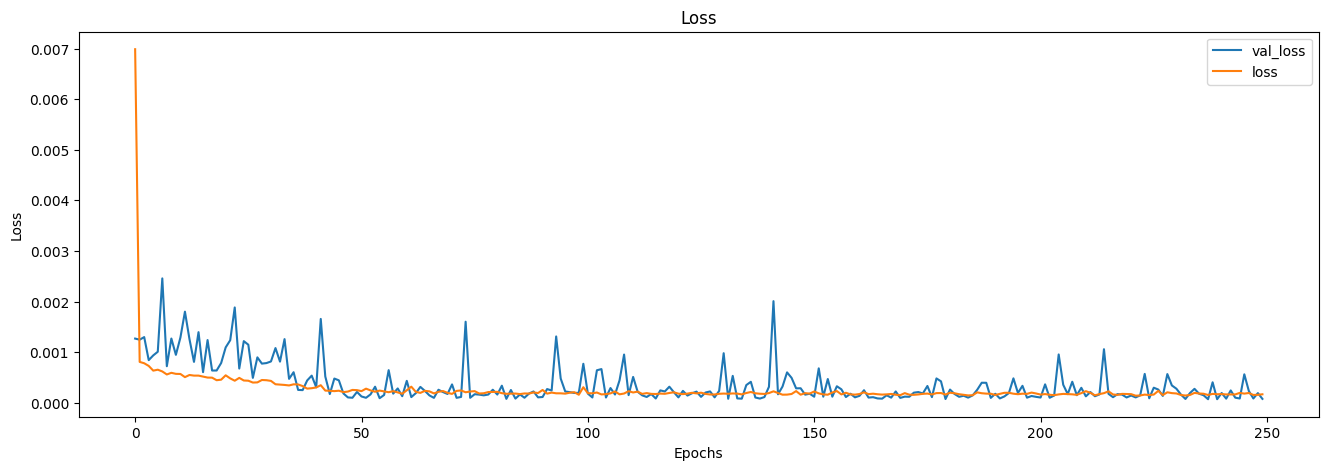

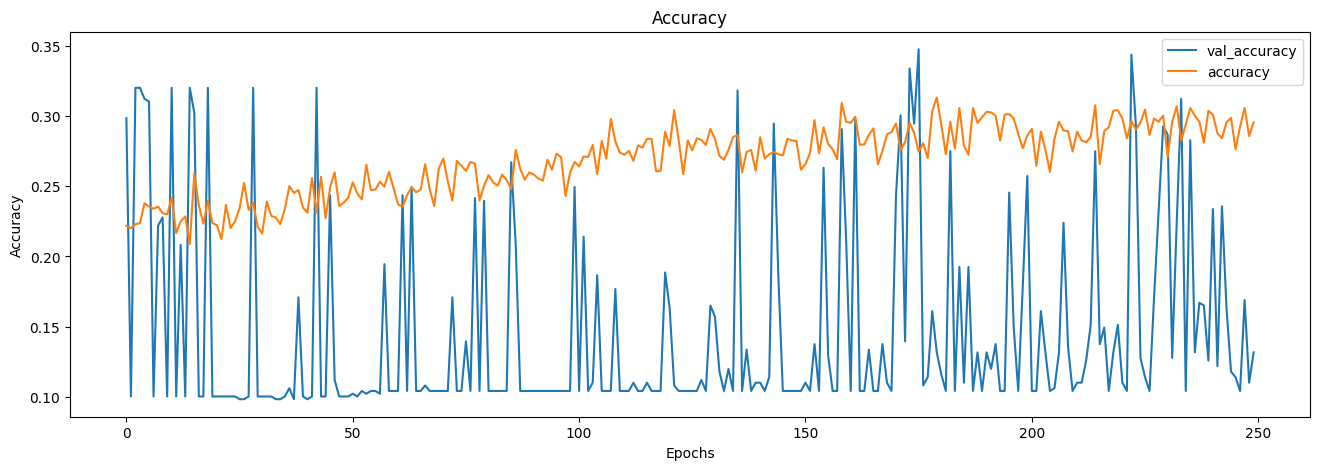

In [127]:
visualize_training_results(history)

In [128]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [7.629525498487055e-05, 0.13163064420223236]


In [129]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)


y_pred = scaler.inverse_transform(y_pred)

y_test = scaler.inverse_transform(y_test)



16/16 [==============================] - 2s 12ms/step
y_pred (509, 5)
y_test (509, 5)


In [130]:
#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

MAPE: 2.4870%
RMSE: 1121102502.7185
MSE: 1256870821601660928.0000
MAE:365477523.7201


In [131]:
y_pred

array([[4.9655398e+04, 5.0655309e+04, 4.6485902e+04, 4.8272914e+04,
        6.6398589e+10],
       [4.6801004e+04, 4.7989090e+04, 4.4793512e+04, 4.6485395e+04,
        5.0284360e+10],
       [4.6868668e+04, 4.8091562e+04, 4.5196523e+04, 4.6832367e+04,
        4.1013486e+10],
       ...,
       [2.3212910e+04, 2.3831371e+04, 2.2314256e+04, 2.3158850e+04,
        2.6932087e+10],
       [2.3179854e+04, 2.3792520e+04, 2.2289242e+04, 2.3124928e+04,
        2.5942612e+10],
       [2.3192299e+04, 2.3794574e+04, 2.2340740e+04, 2.3152648e+04,
        2.2663373e+10]], dtype=float32)

In [132]:
y_test

array([[5.26604805e+04, 5.28537656e+04, 4.32852070e+04, 4.68111289e+04,
        6.52100597e+10],
       [4.68277617e+04, 4.73340547e+04, 4.45613945e+04, 4.60913906e+04,
        4.90077625e+10],
       [4.57747422e+04, 4.72619492e+04, 4.56697383e+04, 4.63914219e+04,
        3.86726570e+10],
       ...,
       [2.31089551e+04, 2.32370781e+04, 2.29113730e+04, 2.30327773e+04,
        2.63578393e+10],
       [2.30307168e+04, 2.34177207e+04, 2.26545938e+04, 2.30787285e+04,
        2.53833356e+10],
       [2.30864512e+04, 2.31635410e+04, 2.29725820e+04, 2.30113398e+04,
        2.18622136e+10]])

In [133]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))

smape: 2.3945%


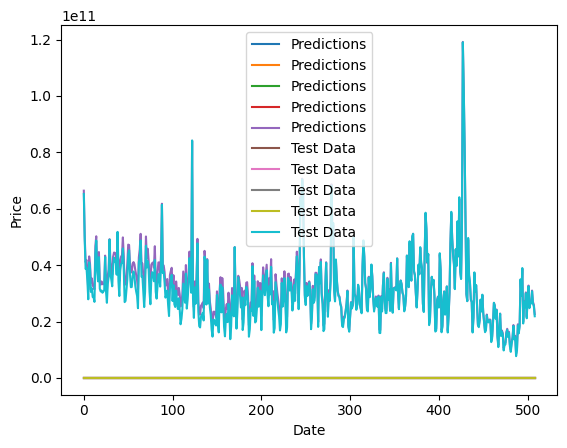

In [134]:
import matplotlib.pyplot as plt

# Assume that you have stored the date information in a variable called 'date'
# Assume that you have stored the predictions in a variable called 'y_pred'
# Assume that you have stored the test data in a variable called 'y_test'

# Plot the test data and predictions on a line chart
plt.plot(y_pred, label='Predictions')
plt.plot(y_test, label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [153]:
# Use the trained model to make predictions
future_predictions = model.predict(X_test[-10:])

# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)
# Creating a DF of the predicted prices


# Print the predictions
print(future_predictions[:,:])



1/1 [==============================] - 0s 282ms/step
[[2.0984904e+04 2.1552168e+04 2.0263688e+04 2.1011625e+04 2.1688504e+10]
 [2.1950100e+04 2.2603564e+04 2.1215266e+04 2.2062621e+04 2.8777103e+10]
 [2.2969443e+04 2.3606033e+04 2.2022604e+04 2.2904309e+04 3.2745562e+10]
 [2.2859893e+04 2.3459816e+04 2.1978699e+04 2.2798770e+04 2.5325974e+10]
 [2.2999449e+04 2.3624027e+04 2.2133426e+04 2.2977244e+04 2.7028398e+10]
 [2.2948145e+04 2.3546453e+04 2.2021988e+04 2.2852533e+04 2.6990801e+10]
 [2.3129463e+04 2.3770721e+04 2.2214406e+04 2.3091346e+04 3.0973198e+10]
 [2.3212910e+04 2.3831371e+04 2.2314256e+04 2.3158850e+04 2.6932087e+10]
 [2.3179854e+04 2.3792520e+04 2.2289242e+04 2.3124928e+04 2.5942612e+10]
 [2.3192299e+04 2.3794574e+04 2.2340740e+04 2.3152648e+04 2.2663373e+10]]


Original values for the next 10 days:
[21011.625 22062.621 22904.309 22798.77  22977.244 22852.533 23091.346
 23158.85  23124.928 23152.648]


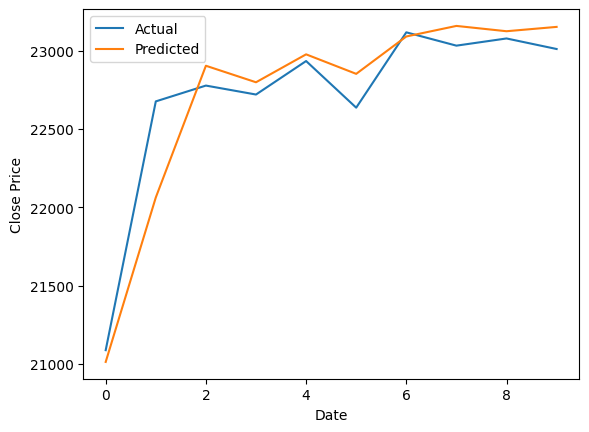

In [137]:
import matplotlib.pyplot as plt



print("Original values for the next 10 days:")
print(future_predictions[:, 3])

# Plot the predictions and the true values
plt.plot(y_test[-10:, 3], label='Actual')
plt.plot(future_predictions[:, 3], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [106]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features 
n_features = data.shape[1]

In [78]:
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=data.index, columns=[data.columns[3]])

    for i in range(1, len(data)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = data[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, 5, 1))

        # Transforming values back to their normal prices
        yhat = sc.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1]+timedelta(days=1), 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[3]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions

In [93]:
sc = MinMaxScaler()
sc.fit(data[['Adj Close']])
actual = pd.DataFrame(sc.inverse_transform(data[['Adj Close']]), 
                      index= data.index, 
                      columns=[data.columns[3]])
actual


#predicted= model.predict(actual)

#predicted.shape





,Adj Close
Date,
2014-09-17,3.081933e+07
2014-09-18,2.860265e+07
2014-09-19,2.660498e+07
2014-09-20,2.755570e+07
2014-09-21,2.687622e+07
...,...
2023-01-23,1.545522e+09
2023-01-24,1.525443e+09
2023-01-25,1.557883e+09


In [109]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(data.tail(n_per_in)).reshape( 1,n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = sc.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=data.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[data.columns[3]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(sc.inverse_transform(data[["Adj Close"]].tail(pers)), 
                      index=data.Close.tail(pers).index, 
                      columns=[data.columns[3]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

InvalidArgumentError: Graph execution error:

Specified a list with shape [?,1] from a tensor with shape [1,5]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_4/lstm_8/PartitionedCall]] [Op:__inference_predict_function_284691]